# (06) DOVES—LapLin—1

**Motivation**: Laplace + DOVES + Lin encoder. ```prior_fit = False```. Device = ```cuda:1``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
device_idx = 1
device = f'cuda:{device_idx}'

model_type = 'laplace'

## Archi: ```<lin|lin>```

In [3]:
cfg_vae, cfg_tr = default_configs('DOVES', model_type, 'lin|lin')

print(f"VAE:\n{cfg_vae}\n\nTrainer:\n{cfg_tr}")

VAE:
{'dataset': 'DOVES', 'n_ch': 32, 'n_latents': 512, 'latent_act': None, 'enc_type': 'lin', 'dec_type': 'lin', 
'enc_bias': False, 'dec_bias': False}

Trainer:
{'temp_anneal_portion': 1.0, 'temp_stop': 1.0, 'temp_anneal_type': 'exp', 'lr': 0.005, 'batch_size': 1000, 
'epochs': 3000, 'optimizer_kws': {'weight_decay': 0.0}, 'grad_clip': 500}

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|  LaplaceVAE |  393.2 K   |
|     ---     |    ---     |
|    fc_enc   |  262.1 K   |
|    fc_dec   |  131.1 K   |
+-------------+------------+

laplace_DOVES_z-512_<lin|lin>
mc_b1000-ep3000-lr(0.005)_beta(1:0x0.5)_temp(1:exp-1)_gr(500)_(2024_05_06,18:44)

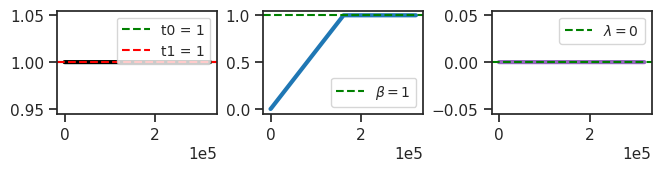

In [4]:
vae = MODEL_CLASSES[model_type](CFG_CLASSES[model_type](**cfg_vae))
tr = TrainerVAE(vae, ConfigTrainVAE(**cfg_tr), device=device)

vae.print()
print(f"{vae.cfg.name()}\n{tr.cfg.name()}_({vae.timestamp})\n")
tr.show_schedules()

In [5]:
vae.fc_enc.bias, vae.fc_dec.bias

(None, None)

### Train

In [ ]:
# comment = f"..._{tr.cfg.name()}"
comment = tr.cfg.name()
tr.train(comment=comment)

epoch # 1904, avg loss: 170.036181:  63%|██████████████▌        | 1904/3000 [40:37<28:26,  1.56s/it]

### Loss vld (freeze)

In [7]:
data, loss, etc = tr.validate()

_loss = {k: v.mean() for k, v in loss.items()}
_loss['tot'] = _loss['mse'] + _loss['kl']
print(_loss)

{'mse': 126.911865, 'kl': 40.444523, 'kl_diag': 0.07850062, 'tot': 167.35638}

In [10]:
### Was: categorical with prior fit

{'mse': 165.39445, 'kl': 5.4255557, 'kl_diag': 5.414346, 'tot': 170.82}

In [26]:
### Was: fixed prior

{'mse': 165.01498, 'kl': 5.632016, 'kl_diag': 5.6216135, 'tot': 170.647}

{'mse': 134.10709, 'kl': 28.86082, 'kl_diag': 0.056184433, 'tot': 162.96791}

{'mse': 133.72597, 'kl': 28.916742, 'kl_diag': 0.05594784, 'tot': 162.64272}

{'mse': 132.80032, 'kl': 29.794188, 'kl_diag': 0.05768895, 'tot': 162.59451}

### Plot enc/dec weights

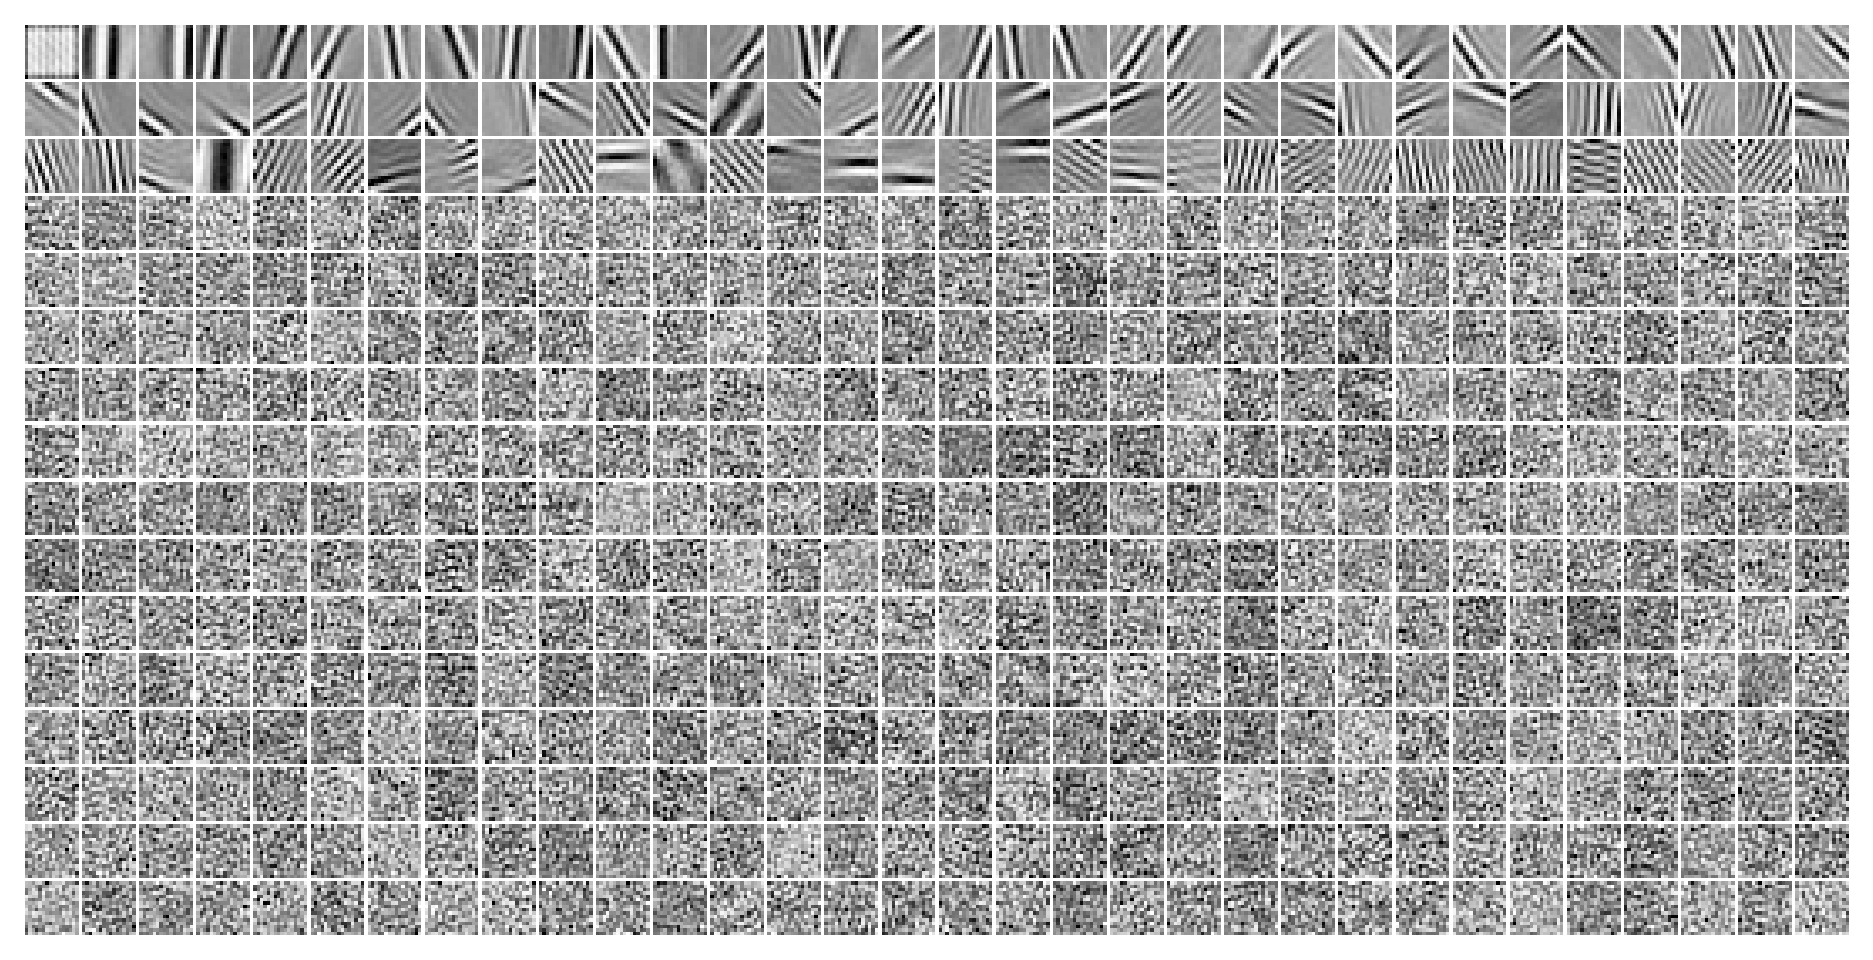

In [8]:
vae.show(dpi=250, order=np.argsort(flatten_np(etc['scale'], start_dim=1).mean(0)));

### Some more distributions

In [9]:
tr.model.temp, tr.cfg.kl_beta

(tensor(1., device='cuda:1'), 1.0)

In [10]:
from figures.imgs import plot_weights

In [11]:
dead_thres = 0.1

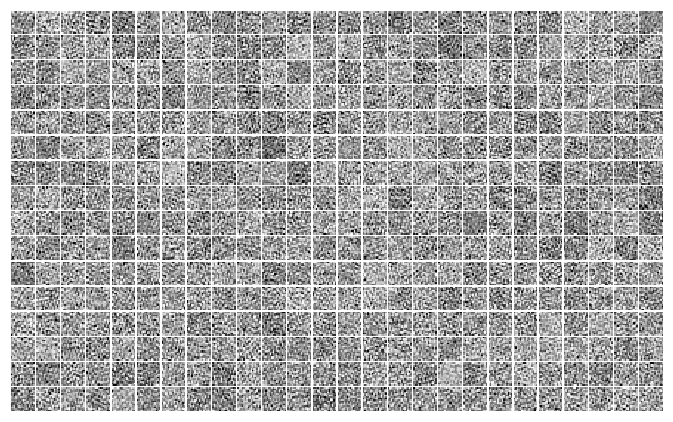

In [12]:
try:
    ind = np.where(loss['kl_diag'] < dead_thres)[0]
    plot_weights(vae.fc_dec.weight.data.T.reshape(-1, 16, 16)[ind], nrows=16, dpi=110);
except ValueError:
    pass

In [13]:
try:
    ind = np.where(tonp(vae.log_scale.squeeze()) > 1)[0]
    plot_weights(vae.fc_dec.weight.data.T.reshape(-1, 16, 16)[ind], nrows=1, dpi=15);
except ValueError:
    pass

## Loggabor analysis

In [18]:
dead_thres = 0.1
dead = loss['kl_diag'] < dead_thres

In [19]:
from analysis.loggabor import fit_loggabor
from figures.theta import plot_theta
from figures.imgs import plot_weights

In [27]:
from analysis import loggabor
import importlib

importlib.reload(loggabor)

<module 'analysis.loggabor' from '/home/hadi/Dropbox/git/_PoissonVAE/analysis/loggabor.py'>

In [28]:
results = loggabor.fit_loggabor(tr, verbose=True)

  0%|             | 2/512 [00:00<00:39, 12.84it/s]

  3%|▎           | 13/512 [00:01<00:41, 12.06it/s]

  4%|▌           | 22/512 [00:02<00:47, 10.32it/s]

  7%|▊           | 35/512 [00:03<00:44, 10.73it/s]

  8%|█           | 43/512 [00:04<00:43, 10.81it/s]

 10%|█▏          | 50/512 [00:04<00:54,  8.47it/s]

 11%|█▎          | 58/512 [00:05<00:28, 15.82it/s]

 16%|█▉          | 82/512 [00:09<00:55,  7.70it/s]

 16%|█▉          | 84/512 [00:09<00:53,  8.00it/s]

 19%|██▎         | 99/512 [00:12<01:28,  4.66it/s]

 21%|██▎        | 110/512 [00:14<00:52,  7.61it/s]

 25%|██▊        | 128/512 [00:17<00:32, 11.87it/s]

 26%|██▉        | 134/512 [00:17<00:22, 16.66it/s]

 27%|██▉        | 136/512 [00:17<00:26, 14.34it/s]

 28%|███        | 144/512 [00:20<01:14,  4.94it/s]

 35%|███▊       | 177/512 [00:24<00:24, 13.41it/s]

 40%|████▍      | 205/512 [00:29<00:44,  6.90it/s]

 41%|████▌      | 211/512 [00:31<01:16,  3.95it/s]

 43%|████▋      | 219/512 [00:32<00:34,  8.49it/s]

 47%|█████▏     | 240/512 [00:35<00:32,  8.43it/s]

 49%|█████▍     | 251/512 [00:35<00:18, 13.91it/s]

 52%|█████▋     | 265/512 [00:37<00:25,  9.62it/s]

 59%|██████▌    | 303/512 [00:41<00:13, 15.77it/s]

 62%|██████▉    | 320/512 [00:43<00:13, 14.28it/s]

 64%|███████    | 326/512 [00:44<00:14, 12.42it/s]

 71%|███████▊   | 364/512 [00:48<00:11, 12.84it/s]

 78%|████████▌  | 398/512 [00:53<00:08, 14.22it/s]

 79%|████████▋  | 402/512 [00:54<00:08, 13.13it/s]

 81%|████████▉  | 416/512 [00:55<00:06, 14.66it/s]

 82%|████████▉  | 418/512 [00:55<00:07, 13.15it/s]

 86%|█████████▍ | 439/512 [00:58<00:08,  8.28it/s]

 92%|██████████ | 471/512 [01:02<00:05,  7.17it/s]

 95%|██████████▍| 486/512 [01:05<00:03,  8.05it/s]

 96%|██████████▌| 494/512 [01:06<00:01,  9.93it/s]

 97%|██████████▋| 499/512 [01:06<00:01, 12.02it/s]

 99%|██████████▊| 506/512 [01:08<00:01,  5.33it/s]

 99%|██████████▉| 508/512 [01:09<00:00,  6.19it/s]

100%|███████████| 512/512 [01:09<00:00,  7.39it/s]

512

(511, 9)

ValueError: Length of values (512) does not match length of index (511)

In [ ]:
results.loc[results['sf_0'] > 10, 'sf_0'] = np.nan
results.iloc[np.logical_or(dead, np.isnan(results['theta']))] = np.nan
results.describe()

In [ ]:
try:
    key = results.columns[-1] if tr.model.cfg.fit_prior else 'kl'
    rates_axial = results.loc[(results['label'] == 'axial') & ~dead, key].values
    rates_oblique = results.loc[(results['label'] == 'oblique') & ~dead, key].values
    print(f"{sp_stats.mannwhitneyu(rates_axial, rates_oblique, method='auto')}")
    a, b = len(rates_axial), len(rates_oblique)
    print(f"portions,   axial: {a/(a+b):0.2f} —— vs. —— oblique: {b/(a+b):0.2f}")
except KeyError:
    pass

In [ ]:
rates_axial = results.loc[(results['label'] == 'axial') & ~dead, 'phase'].values
rates_oblique = results.loc[(results['label'] == 'oblique') & ~dead, 'phase'].values

print(f"{sp_stats.mannwhitneyu(rates_axial, rates_oblique, method='auto')}")

In [ ]:
a, b = len(rates_axial), len(rates_oblique)
a / (a+b), b / (a+b)

In [ ]:
order = np.argsort(results['sf_0'].values)
_ = tr.model.show(order=order)

In [ ]:
w_dec = tonp(tr.model.fc_dec.weight.data)
w_dec = w_dec.T.reshape(-1, 16, 16)
ids = np.argsort(results['sf_0'].values)

In [ ]:
plot_weights(w_dec[ids[:32]], nrows=2, dpi=130)
plt.show()

plot_weights(w_dec[ids[-32:]], nrows=2, dpi=130)
plt.show()